# Tests of cosmic homogeneity
This notebook is part of the *DoCrimes* project <https://github.com/davidwhogg/DoCrimes>.

## Authors
- **David W. Hogg** (NYU) (MPIA) (Flatiron)

## License
- This code is licensed for re-use under the open-source *MIT License*. See the file `LICENSE` for more information.

## To-do items and bugs:
- Don't display the fractal-dimension-related pair counts as a function of sky hemisphere (it adds nothing to split it).
- Put error bars of some kind on the points in the plots.
- Make a quantitative estimate of the fractal dimension.
- Switch to a color scheme that is good in black-and-white.

In [60]:
import numpy as np
import pickle
import os
from scipy.spatial import KDTree
from astropy.io import fits
from astropy.io import ascii
from astropy.table import QTable
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck18
import pylab as plt

In [2]:
clobber = False
rng = np.random.default_rng(17)

In [3]:
# print(plt.rcParams.keys())
plt.rcParams['lines.markeredgecolor'] = 'none'
plt.rcParams['figure.figsize'] = [8.0, 4.0]

In [4]:
datafd = fits.open("../data/gaia_G20.0.fits") # note terrible file path
data_table = QTable(datafd[1].data)
print(len(data_table))

648842


In [5]:
print(data_table.colnames)

['ra', 'dec', 'redshift_qsoc', 'l', 'b', 'source_id', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'redshift_qsoc_lower', 'redshift_qsoc_upper', 'zscore_qsoc', 'flags_qsoc', 'allwise_oid', 'w1mpro', 'w2mpro', 'g_rp', 'bp_g', 'bp_rp', 'g_w1', 'w1_w2', 'ebv', 'A_v', 'redshift_spz', 'redshift_sdss']


In [6]:
randfd = fits.open("../data/random_stardustm1064_G20.0_10x.fits") # note terrible file path
rand_table = QTable(randfd[1].data)
print(len(rand_table))

6489060


In [7]:
# cut everything by the dust map
ebvlim = 0.05
Id = data_table['ebv'] < ebvlim
data_table = data_table[Id]
Ir = rand_table['ebv'] < ebvlim
rand_table = rand_table[Ir]

In [8]:
# Add l, b to the random catalog.
randc = SkyCoord(ra=rand_table['ra']*u.degree, dec=rand_table['dec']*u.degree, frame='icrs')
rand_table['l'] = randc.galactic.l.to(u.deg).value
rand_table['b'] = randc.galactic.b.to(u.deg).value

In [50]:
# Overwrite l, b in the data catalog.
datac = SkyCoord(ra=data_table['ra']*u.degree, dec=data_table['dec']*u.degree, frame='icrs')
data_table['l'] = datac.galactic.l.to(u.deg).value
data_table['b'] = datac.galactic.b.to(u.deg).value

In [9]:
# make two hemsisphere samples
dhi, dlo = data_table['b'] > 0., data_table['b'] < 0.
rhi, rlo = rand_table['b'] > 0., rand_table['b'] < 0.

Text(0, 0.5, 'Dec (deg)')

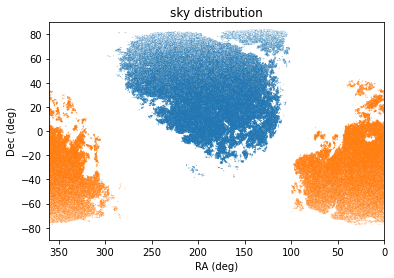

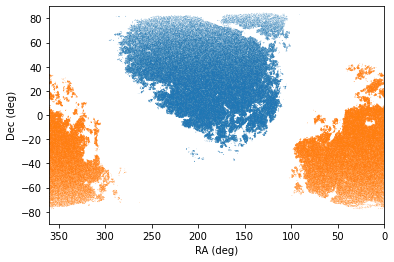

In [56]:
scatterkwargs = {'marker':'o',
                 's': 0.3,
                 'alpha':0.5, 
                 'edgecolors': 'none',
                }
for I in [dhi, dlo]:
    plt.scatter(data_table['ra'][I], data_table['dec'][I],
                **scatterkwargs)
plt.xlim(360, 0)
plt.ylim(-90, 90)
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.title("sky distribution")
dpi = 300
plt.savefig("radec.png", dpi=dpi)

plot_rhi, plot_rlo = rhi.copy(), rlo.copy()
plot_rhi[len(data_table):] = False
plot_rlo[len(data_table):] = False
plt.figure()
for I in [plot_rhi, plot_rlo]:
    plt.scatter(rand_table['ra'][I], rand_table['dec'][I],
                **scatterkwargs)
plt.xlim(360, 0)
plt.ylim(-90, 90)
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")

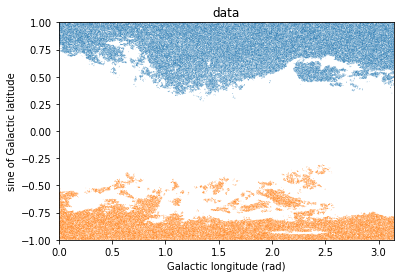

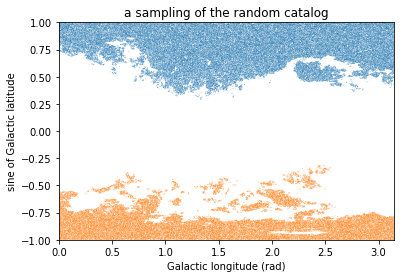

In [57]:
for I in [dhi, dlo]:
    plt.scatter(data_table['l'][I] * np.pi / 180., np.sin(data_table['b'][I] * np.pi / 180.),
                **scatterkwargs)
plt.ylim(-1, 1)
plt.xlim(0, np.pi)
plt.xlabel("Galactic longitude (rad)")
plt.ylabel("sine of Galactic latitude")
plt.title("data")
plt.savefig("lb.png", dpi=dpi)

plt.figure()
for I in [plot_rhi, plot_rlo]:
    plt.scatter(rand_table['l'][I] * np.pi / 180., np.sin(rand_table['b'][I] * np.pi / 180.),
                **scatterkwargs)
plt.ylim(-1, 1)
plt.xlim(0, np.pi)
plt.xlabel("Galactic longitude (rad)")
plt.ylabel("sine of Galactic latitude")
plt.title("a sampling of the random catalog")
plt.savefig("lb_random.png")

In [58]:
def hogg_sky_plot(data, title, Is, **kwargs):
    """
    ## inputs:
    - `data`: table that must contain `l` longitudes in deg and `b` latitudes in deg.
    - `title`: plot title
    - `Is` : a list of boolean indices that index the data.
    - `**kwargs`: passed to scatter.
    
    ## bugs:
    - Should probably use astropy units.
    """
    xoff = np.sqrt(2.)
    def _project(ls, bs, xoff):
        thetas = ls
        rs = np.sqrt(2. - 2. * np.sin(np.abs(bs)))
        return (rs * np.cos(thetas) - xoff) * np.sign(bs) * -1., rs * np.sin(thetas)
    def _plot_grid(ax, xoff, fontdict=None):
        # make background
        ls1 = np.arange(0., 1.0001, 0.001) * np.pi
        ls2 = 2. * np.pi - ls1
        bs = np.zeros_like(ls1) + 0.0001 * np.pi
        for sign in (1., -1.):
            xs, ys1 = _project(ls1, sign * bs, xoff)
            _,  ys2 = _project(ls2, sign * bs, xoff)
            ax.fill_between(xs, ys1, ys2, color="w", zorder=-np.Inf)
        # make l grid
        bs = np.array([0.5, 0.1, 0.0001]) * np.pi
        for l in np.arange(0, 359, 30).astype(int):
            ls = np.zeros_like(bs) + l * np.pi / 180.
            for sign in (1., -1.):
                xs, ys = _project(ls, sign * bs, xoff)
                ax.plot(xs, ys, "k-", lw=0.5, alpha=0.5)
                if fontdict is not None:
                    lstr = "{}".format(l)
                    ax.text(xs[-2], ys[-2], lstr, fontdict=fontdict)
        # make b grid
        ls = np.arange(0., 360.01, 1.) * np.pi / 180.
        for b in (10, 30, 50, 70):
            bs = np.zeros_like(ls) + b * np.pi / 180.
            for sign in (1., -1.):
                xs, ys = _project(ls, sign * bs, xoff)
                ax.plot(xs, ys, "k-", lw=0.5, alpha=0.5)
                if fontdict is not None:
                    bstr = "{}".format(b)
                    ax.text(xs[285], ys[285], bstr, fontdict=fontdict)
    xs, ys = _project(data['l'] * np.pi / 180., data['b'] * np.pi / 180., xoff)
    fig = plt.figure()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    for I in Is:
        ax.scatter(xs[I], ys[I], **kwargs)
    labeldict = {'fontsize': 8,
                 'fontweight': 1,
                 'verticalalignment': 'center',
                 'horizontalalignment': 'center',
                 'alpha': 0.5}
    _plot_grid(ax, xoff, labeldict)
    ax.set_xlim(-2 * xoff, 2 * xoff)
    ax.set_ylim(-xoff, xoff)
    ax.set_aspect('equal', adjustable='box')
    titledict = {'fontsize': plt.rcParams['axes.titlesize'],
                 'fontweight': plt.rcParams['axes.titleweight'],
                 'verticalalignment': 'top',
                 'horizontalalignment': 'center'}
    ax.text(0., 1.35, title, fontdict=titledict)
    return fig

In [ ]:
table = ascii.read("data/cds.dat")
>>> table = ascii.read("data/vizier/table1.dat", readme="data/vizier/ReadMe")


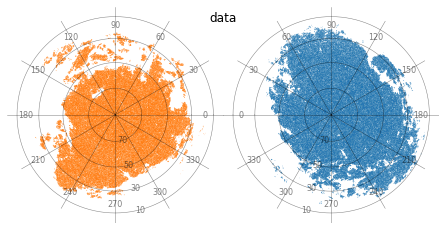

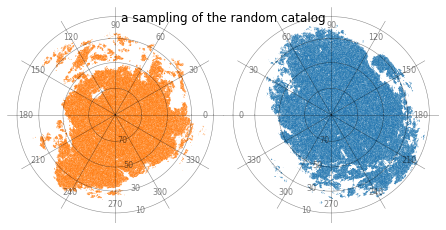

In [59]:
fig = hogg_sky_plot(data_table, "data",
                    [dhi, dlo], **scatterkwargs)
fig.savefig("lb_better.png", dpi=dpi, bbox_inches="tight")
fig = hogg_sky_plot(rand_table, "a sampling of the random catalog",
                    [plot_rhi, plot_rlo], **scatterkwargs)
fig.savefig("lb_random_better.png", dpi=dpi, bbox_inches="tight")

In [14]:
factor = len(data_table) / len(rand_table)

In [15]:
bins = np.arange(0., 4.501, 0.1)
bincntrs = 0.5 * (bins[1:] + bins[:-1])
binwids = (bins[1:] - bins[:-1])
nzhi, _ = np.histogram(data_table['redshift_spz'][dhi], bins)
nzhi = nzhi.astype(float) / (np.sum(rhi) * factor) / binwids
nzlo, _ = np.histogram(data_table['redshift_spz'][dlo], bins)
nzlo = nzlo.astype(float) / (np.sum(rlo) * factor) / binwids

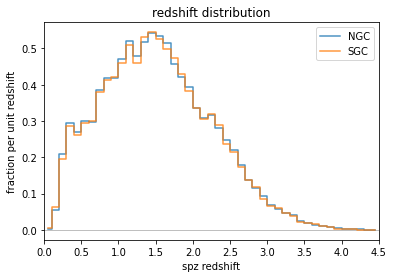

In [16]:
stepkwargs = {'alpha': 0.8,
              'where': 'mid',
             }
plt.axhline(0., color="k", lw = 0.5, alpha=0.5)
plt.step(bincntrs, nzhi, label="NGC", **stepkwargs)
plt.step(bincntrs, nzlo, label="SGC", **stepkwargs)
plt.legend()
plt.xlim(0., 4.5)
plt.xlabel("spz redshift")
plt.ylabel("fraction per unit redshift")
plt.title("redshift distribution")
plt.savefig("zhist.png", dpi=dpi)

In [17]:
# Give the random points redshifts.
rand_table['redshift_spz'] = rng.choice(data_table['redshift_spz'],
                                        size=len(rand_table), replace=True)

In [18]:
# Get comoving LOS distances.
# This could be sped up if we noted that many redshifts are repeated!
data_table['comoving_distance'] = Planck18.comoving_distance(data_table['redshift_spz']).value
rand_table['comoving_distance'] = Planck18.comoving_distance(rand_table['redshift_spz']).value

In [19]:
# Cartesian positions in comoving space.
def add_xyz(table):
    r = table['comoving_distance']
    cb = np.cos(table['b'] * np.pi / 180.)
    x = r * cb * np.cos(table['l'] * np.pi / 180.)
    y = r * cb * np.sin(table['l'] * np.pi / 180.)
    z = r * np.sin(table['b'] * np.pi / 180.)
    table['xyz'] = np.array([x, y, z]).T
    return

add_xyz(data_table)
add_xyz(rand_table)

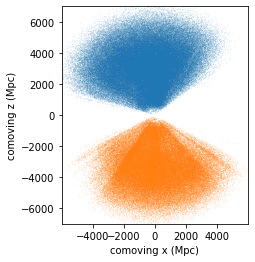

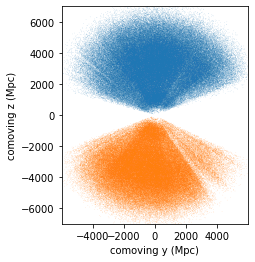

In [20]:
for I in [dhi, dlo]:
    plt.scatter(data_table['xyz'][I,0], data_table['xyz'][I,2],
                **scatterkwargs)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-5999, 5999)
plt.ylim(-7000, 7000)
plt.xlabel("comoving x (Mpc)")
plt.ylabel("comoving z (Mpc)")
plt.savefig("cartesianxz.png", dpi=dpi)
plt.figure()
for I in [dhi, dlo]:
    plt.scatter(data_table['xyz'][I,1], data_table['xyz'][I,2],
                **scatterkwargs)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-5999, 5999)
plt.ylim(-7000, 7000)
plt.xlabel("comoving y (Mpc)")
plt.ylabel("comoving z (Mpc)")
plt.savefig("cartesianyz.png", dpi=dpi)

In [21]:
# Make trees in preparation for counting pairs.
data_tree = KDTree(data_table['xyz'])
dhi_tree = KDTree(data_table['xyz'][dhi])
dlo_tree = KDTree(data_table['xyz'][dlo])
rand_tree = KDTree(rand_table['xyz'])
rhi_tree = KDTree(rand_table['xyz'][rhi])
rlo_tree = KDTree(rand_table['xyz'][rlo])

In [29]:
# Make or read the DD counts (cumulative) out to various radii.
# Note the controversial `- N` adjustments to the self-counts.
DD_hi = None
fn = "dd.pkl"
if os.path.exists(fn):
    with open(fn, "rb") as fd:
        rs, DD_hi, DD_lo = pickle.load(fd)
if DD_hi is None or clobber:
    rs = np.exp(np.arange(np.log(5.), np.log(1000.), 0.25))
    DD_hi = (dhi_tree.count_neighbors(data_tree, rs).astype(float)
             - np.sum(dhi)) # controversial
    DD_lo = (dlo_tree.count_neighbors(data_tree, rs).astype(float)
             - np.sum(dlo)) # controversial
    with open(fn, "wb") as fd:
        pickle.dump((rs, DD_hi, DD_lo), fd)

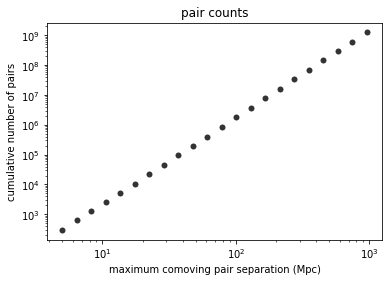

In [39]:
plotkwargs = {'linestyle': 'none', 'marker': 'o', 'alpha': 0.8, }
plt.plot(rs, DD_hi + DD_lo, color="k", **plotkwargs)
plt.loglog()
plt.xlabel("maximum comoving pair separation (Mpc)")
plt.ylabel("cumulative number of pairs")
plt.title("pair counts")
plt.savefig("cumulativeDD.png", dpi=dpi)

In [33]:
# Make DR counts (symmetrically).
DR_hi = None
fn = "dr.pkl"
if os.path.exists(fn):
    with open(fn, "rb") as fd:
        _rs, DR_hi, RD_hi, DR_lo, RD_lo = pickle.load(fd)
        assert np.all(_rs == rs)
if DR_hi is None or clobber:
    DR_hi = factor * dhi_tree.count_neighbors(rand_tree, rs).astype(float)
    RD_hi = factor * rhi_tree.count_neighbors(data_tree, rs).astype(float)
    DR_lo = factor * dlo_tree.count_neighbors(rand_tree, rs).astype(float)
    RD_lo = factor * rlo_tree.count_neighbors(data_tree, rs).astype(float)
    with open(fn, "wb") as fd:
        pickle.dump((rs, DR_hi, RD_hi, DR_lo, RD_lo), fd)

In [45]:
DD = DD_hi + DD_lo
DR = DR_hi + DR_lo
RD = RD_hi + RD_lo
RR = RR_hi + RR_lo

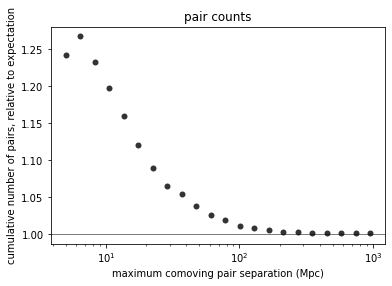

In [47]:
uniform = rs ** 3
plt.axhline(1, color="k", lw=1, alpha=0.5)
plt.plot(rs, DD / (DR + RD - RR), color="k", **plotkwargs)
plt.semilogx()
plt.xlabel("maximum comoving pair separation (Mpc)")
plt.ylabel("cumulative number of pairs, relative to expectation")
plt.title("pair counts")
plt.savefig("cumulativeDD_DR.png", dpi=dpi)

In [34]:
# Make RR counts.
# Note the controversial `- N` adjustments to the self-counts.
# They could be avoided if there were multiple randoms cross-correlated.
RR_hi = None
fn = "rr.pkl"
if os.path.exists(fn):
    with open(fn, "rb") as fd:
        _rs, RR_hi, RR_lo = pickle.load(fd)
        assert np.all(_rs == rs)
if RR_hi is None or clobber:
    RR_hi = factor ** 2 * (rhi_tree.count_neighbors(rand_tree, rs).astype(float)
                           - np.sum(rhi)) # controversial
    RR_lo = factor ** 2 * (rlo_tree.count_neighbors(rand_tree, rs).astype(float)
                           - np.sum(rlo)) # controversial
    with open(fn, "wb") as fd:
        pickle.dump((rs, RR_hi, RR_lo), fd)

In [35]:
# Now turn the cumulative counts into differential counts
dDD_hi = DD_hi[1:] - DD_hi[:-1]
dDD_lo = DD_lo[1:] - DD_lo[:-1]
d2DR_hi = DR_hi[1:] - DR_hi[:-1] + RD_hi[1:] - RD_hi[:-1]
d2DR_lo = DR_lo[1:] - DR_lo[:-1] + RD_lo[1:] - RD_lo[:-1]
dRR_hi = RR_hi[1:] - RR_hi[:-1]
dRR_lo = RR_lo[1:] - RR_lo[:-1]
rcs = np.exp(0.5 * (np.log(rs[1:]) + np.log(rs[:-1])))

In [36]:
LS_hi = (dDD_hi - d2DR_hi + dRR_hi) / dRR_hi
LS_lo = (dDD_lo - d2DR_lo + dRR_lo) / dRR_lo

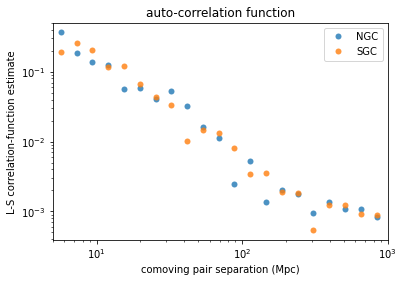

In [37]:
plt.axhline(0., color="k", lw=0.5, alpha=0.5)
plt.plot(rcs, LS_hi, label="NGC", **plotkwargs)
plt.plot(rcs, LS_lo, label="SGC", **plotkwargs)
plt.loglog()
plt.legend()
plt.xlim(5., 1000.)
plt.xlabel("comoving pair separation (Mpc)")
plt.ylabel("L-S correlation-function estimate")
plt.title("auto-correlation function")
plt.savefig("corrfunc.png", dpi=dpi)